In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mne.decoding import CSP
from sklearn.model_selection import train_test_split
from pyriemann.estimation import Covariances
from pyriemann.classification import MDM
from pyriemann.tangentspace import TangentSpace

from processing.preprocessing import BCIDataProcessor

recording_path_1 = '../recordings/recording_relax2.raw.fif'
recording_path_2 = '../recordings/recording_relax3.raw.fif'
rescale = True
window_size = 2
window_overlap = 0.33
filter_method = 'iir'
l_freq, h_freq = 10, 20

processor = BCIDataProcessor(recording_path_1, l_freq=l_freq, h_freq=h_freq, window_size=window_size,
                             window_overlap=window_overlap, rescale=rescale, filter_method=filter_method)
data = processor.process()
# Only select relax and focus
data = {label: data[label] for label in data.keys() if label in ['relax', 'focus']}
data

{'relax': array([[[-2.75859755e-09,  6.58822355e-06,  1.19196667e-05, ...,
          -6.53445754e-06, -8.10259155e-06, -8.84459835e-06],
         [-1.05771001e-09, -3.81782756e-07, -7.76688674e-07, ...,
          -3.01867316e-06, -5.39087651e-06, -7.42446293e-06],
         [-2.85816626e-09,  1.36934219e-08,  4.52812403e-08, ...,
          -4.97722714e-06, -7.74024405e-06, -9.75942371e-06],
         ...,
         [-7.39293400e-10,  2.76738098e-06,  4.86841659e-06, ...,
          -1.33488083e-06, -2.17059583e-06, -2.78339685e-06],
         [-1.39442420e-09, -8.90089752e-08, -1.86083199e-07, ...,
          -3.46851677e-07, -1.29134428e-06, -2.16159753e-06],
         [-1.26045405e-09, -2.42412880e-06, -4.40465518e-06, ...,
           1.96653584e-06,  7.46746826e-07, -6.00096828e-07]],
 
        [[ 7.22537962e-06,  2.62723408e-06, -2.09849110e-06, ...,
           4.23855923e-06,  6.00172331e-06,  6.82361705e-06],
         [ 3.71442434e-06,  1.47105855e-06, -6.63788315e-07, ...,
          -5

In [2]:
X = np.concatenate(list(data.values()), axis=0)
y = np.concatenate([[label] * data[label].shape[0] for label in data.keys()])  # (samples,)
X.shape, y.shape

((48, 8, 500), (48,))

In [3]:
from sklearn.pipeline import Pipeline
from pyriemann.classification import TSClassifier

clf = Pipeline(steps=[('cov', Covariances(estimator='lwf')), ('ts', TSClassifier(metric='riemann'))])
clf.fit(X, y)
y_pred = clf.predict(X)
print(f"Training accuracy: {np.mean(y_pred == y)}")

Training accuracy: 0.9583333333333334


In [4]:
# Load the second recording and validate on that
processor = BCIDataProcessor(recording_path_2, l_freq=l_freq, h_freq=h_freq, window_size=window_size,
                             window_overlap=window_overlap, rescale=rescale, filter_method=filter_method)
data = processor.process()
# Only select relax/focus
data = {label: data[label] for label in data.keys() if label in ['relax', 'focus']}
data

{'relax': array([[[-3.00207443e-10, -5.70210178e-06, -1.04791017e-05, ...,
           3.16270924e-06,  4.85458244e-06,  5.92251916e-06],
         [-6.52361091e-10, -9.84172183e-07, -1.86712781e-06, ...,
           5.21267974e-07,  2.39414498e-06,  3.87174178e-06],
         [-5.82325307e-10, -5.92767071e-07, -1.12299648e-06, ...,
           1.22569326e-06,  2.54620045e-06,  3.48927456e-06],
         ...,
         [-1.76256307e-09, -1.48573862e-06, -2.56163630e-06, ...,
           7.20887029e-06,  7.73060739e-06,  7.40922253e-06],
         [-1.15709216e-09, -1.13228087e-06, -2.04163925e-06, ...,
           1.30009994e-06,  2.24901922e-06,  2.90034921e-06],
         [-9.69460846e-11, -2.25287716e-06, -4.18742334e-06, ...,
           4.55470623e-06,  5.65412801e-06,  6.03537239e-06]],
 
        [[ 8.17646552e-06,  8.00788527e-06,  6.44657189e-06, ...,
           3.08425385e-06,  5.38125508e-06,  7.45286635e-06],
         [ 7.61118398e-06,  7.96037903e-06,  7.13830502e-06, ...,
          -1

In [5]:
# Prepare the data for validation
X_val = np.concatenate(list(data.values()), axis=0)
y_val = np.concatenate([[label] * data[label].shape[0] for label in data.keys()])  # (samples,)

# Evaluate the trained model on the validation data
val_score = clf.score(X_val, y_val)
print(f"Validation accuracy: {val_score}")

Validation accuracy: 0.8541666666666666


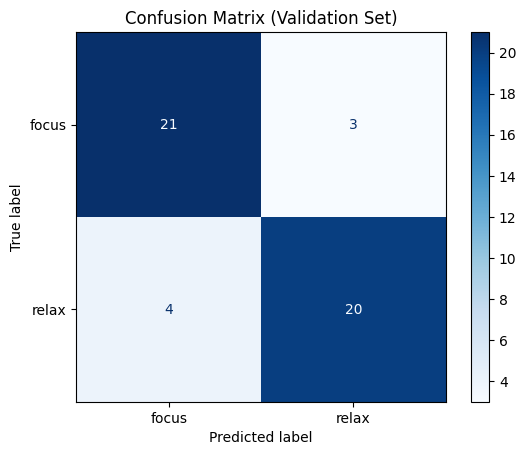

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions for the validation data
y_val_pred = clf.predict(X_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_val))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Validation Set)")
plt.show()

In [10]:
import re
import numpy as np
from pathlib import Path


def summarize_cv_accuracies(log_path: str | Path) -> None:
    """
    Parse a log file produced by the hyper-parameter search and report the
    mean and sample-standard-deviation of all 'Mean CV accuracy' figures.

    Parameters
    ----------
    log_path : str | Path
        Path to the text file containing the printed output.
    """
    log_path = Path(log_path).expanduser()
    if not log_path.is_file():
        raise FileNotFoundError(f"Cannot find log file: {log_path}")

    # Matches both 'Mean CV accuracy   : 0.923' and the final summary line
    pattern = re.compile(r'Mean CV accuracy\s*:\s*([0-9]*\.?[0-9]+)',
                         flags=re.IGNORECASE)

    accuracies = []
    with log_path.open('r', encoding='utf-8') as fh:
        for line in fh:
            m = pattern.search(line)
            if m:
                accuracies.append(float(m.group(1)))

    if not accuracies:
        raise RuntimeError("No 'Mean CV accuracy' entries found in the log.")

    acc_arr = np.asarray(accuracies, dtype=float)
    mean_acc = acc_arr.mean()
    std_acc = acc_arr.std(ddof=1)  # sample standard deviation

    # ----- 95 % confidence interval for the mean ---------------------------
    n = acc_arr.size
    alpha = 0.05
    try:
        from scipy.stats import t
        t_crit = t.ppf(1 - alpha / 2, df=n - 1)  # two-tailed critical value
    except ModuleNotFoundError:
        # Fall back to the normal approximation if SciPy is absent and n is large.
        if n > 30:
            t_crit = 1.96
        else:
            raise RuntimeError(
                "SciPy is required for an exact CI when the sample size ≤ 30."
            )

    half_width = t_crit * std_acc / np.sqrt(n)
    ci_low, ci_high = mean_acc - half_width, mean_acc + half_width

    print(f'Collected {n} accuracy values.')
    print(f'Mean accuracy                : {mean_acc:.4f}')
    print(f'Standard deviation (ddof=1)  : {std_acc:.4f}')
    print(f'95 % CI for the mean accuracy: ({ci_low:.4f}, {ci_high:.4f})')

In [11]:
summarize_cv_accuracies('./relax_model_parameter_search_results.txt')

Collected 480 accuracy values.
Mean accuracy                : 0.6951
Standard deviation (ddof=1)  : 0.0275
95 % CI for the mean accuracy: (0.6926, 0.6975)


In [7]:
# Load all the 2-second .npy files from recordings/focus_chunks and recordings/relax_chunks,
# filter them using the same filter and validate our model on them
